Develop an index that samples at regular intervals a grid. Intervals are described by distances in degrees or metres. 

```python

ds.sel(x_2= slice(0, 10)) # returns 10 values every 2 km

ds.sel(x_4= slice(0, 10)) # returns 10 values every 4 km

```

Why not just creating a sampler that does that?


```python

ds # (lat, lon), spatial extent of the domain

ds_5_0, ds_5_0_index = sampler(ds, intervals = (5, 5), origin= (0,0)) # returns a grid by sampling every 5 km starting at index 0

ds_5_0_index # matrix indeces, latlon?

# create a grid that is shifted by 2 km in respect to ds_5_0
ds_5_1, ds_5_1_index = sampler(ds, intervals = (5, 5), origin= (2,2)) # returns a grid by sampling every 5 km starting at index 1 

ds_5_1 # (lat, lon)


# sample from raw data, the sample is actually everything within an area
ds_attrs # (lat, lon), spatial extent of the domain, resolution of the highest attribute

ds_attrs_5_1 = sampler(ds_attrs, ds_5_1_index)


```


Current dev in xarray indexes: https://hackmd.io/Zxw_zCa7Rbynx_iJu6Y3LA?view

Custom indexes in xarray: https://docs.xarray.dev/en/latest/internals/how-to-create-custom-index.html

Xarray contrib handling indexes: https://xoak.readthedocs.io/en/latest/index.html

https://docs.xarray.dev/en/latest/user-guide/terminology.html#term-Index

In [67]:
from typing import Any, Hashable, Mapping, Self

import numpy as np
import pandas as pd
import xarray as xr
from xarray import Index
from xarray.core.indexes import PandasIndex
from xarray.core.indexing import merge_sel_results

In [2]:
class RangeIndex(PandasIndex):
    """A range index.

    This Xarray index uses a `pandas.RangeIndex` internally.
    It can be set from either:

    - a coordinate encapsulating a `pandas.RangeIndex` instance
    - a scalar coordinate (with "start", "stop" and "step" attributes)
    - any arbitrary coordinate (validation is performed by default)
    
    """

    def __init__(
        self,
        array: pd.RangeIndex,
        dim: Hashable,
        coord_dtype: Any = None,
    ):
        assert isinstance(array, pd.RangeIndex)
        super().__init__(array, dim, coord_dtype=coord_dtype)

    @classmethod
    def from_variables(
        cls,
        variables: Mapping[Any, xr.Variable],
        *,
        options: Mapping[str, Any],
    ) -> Self:

        if len(variables) != 1:
            raise ValueError(
                f"RangeIndex only accepts one variable, found {len(variables)} variables"
            )

        name, var = next(iter(variables.items()))

        # case of a scalar coordinate
        if var.ndim == 0:
            idx = pd.RangeIndex(
                start=var.attrs.get("start"),
                stop=var.attrs.get("stop"),
                step=var.attrs.get("step"),
            )
            dim = options.get("dim", name)
            return cls(idx, dim)

        if var.ndim != 1:
            raise ValueError(
                "RangeIndex only accepts a 1-dimensional variable, "
                f"variable {name!r} has {var.ndim} dimensions"
            )
        
        # fastpath (variable encapsulates a pd.RangeIndex)
        # TODO: calling var.to_index() may be expensive?
        if isinstance(var.to_index(), pd.RangeIndex):
            return super().from_variables(variables, options=options)
        
        # case of a 1-d arbitrary coordinate
        var_data = var.data
        start = var_data[0]
        step = var_data[1] - start
        stop = var_data[-1] + step
        if options.get("validate", True):
            np.testing.assert_array_equal(var.data, np.arange(start, stop, step))
        idx = pd.RangeIndex(start=start, stop=stop, step=step)
        return cls(idx, var.dims[0])

    @property
    def start(self):
        return self.index.start

    @property
    def stop(self):
        return self.index.stop

    @property
    def step(self):
        return self.index.step
    
    def _repr_inline_(self, max_width=0):
        return f"RangeIndex(start={self.start}, stop={self.stop}, step={self.step})"


In [ ]:
class RasterIndex(Index):
    def __init__(self, xy_indexes):
        assert len(xy_indexes) == 2

        # must have two distinct dimensions
        dim = [idx.dim for idx in xy_indexes.values()]
        assert dim[0] != dim[1]

        self._xy_indexes = xy_indexes

    @classmethod
    def from_variables(cls, variables):
        assert len(variables) == 2

        xy_indexes = {
            k: PandasIndex.from_variables({k: v}) for k, v in variables.items()
        }

        return cls(xy_indexes)

    def create_variables(self, variables):
        idx_variables = {}

        for index in self._xy_indexes.values():
            idx_variables.update(index.create_variables(variables))

        return idx_variables

    def sel(self, labels):
        results = []

        for k, index in self._xy_indexes.items():
            if k in labels:
                results.append(index.sel({k: labels[k]}))

        return merge_sel_results(results)

In [41]:
ds = xr.Dataset(data_vars= {"data":np.arange(0,1000)},coords={"x": pd.RangeIndex(0, 1_000, 10)}).drop_indexes(["x","data"])
ds


<xarray.Dataset>
Dimensions:  (data: 1000, x: 100)
Coordinates:
    data     (data) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    x        (x) int64 0 10 20 30 40 50 60 70 ... 930 940 950 960 970 980 990
Data variables:
    *empty*

In [44]:
ds.isel(x=99)

<xarray.Dataset>
Dimensions:  (data: 1000)
Coordinates:
    data     (data) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    x        int64 990
Data variables:
    *empty*

In [20]:
ds = ds.set_xindex("x", RangeIndex)
ds

<xarray.Dataset>
Dimensions:  (x: 1000)
Coordinates:
  * x        (x) int64 0 10 20 30 40 50 60 ... 9940 9950 9960 9970 9980 9990
Data variables:
    *empty*

In [21]:
ds.xindexes


Indexes:
    x        RangeIndex(start=0, stop=10000, step=10)

In [25]:
ds.isel(x=10)

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    x        int64 100
Data variables:
    *empty*

In [56]:
air = xr.tutorial.load_dataset("air_temperature")

In [57]:
air = air.drop_indexes(["time", "lon", "lat"])
air

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
    lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
    lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
    time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [ ]:
air = air.assign_coords({"x_2":pd.RangeIndex(0, len(air.lat) , 2) }).drop_indexes("x_2")

In [61]:
air = air.set_xindex("x_2", RangeIndex)

ValueError: those coordinates already have an index: {'x_2'}

In [63]:
air.isel(x_2=3)

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
    lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
    lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
    time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
    x_2      int64 6
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

## SAMPLER


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
from pathlib import Path 
import xarray as xr 

In [3]:
ipath = Path('/mnt/CEPH_PROJECTS/InterTwin/Wflow/full_domain/alps1km')
dyn_vars_ds = xr.open_dataset(ipath / 'inmaps_eobs_eobsd_makkink_86400_2015_2019.nc', decode_coords='all',chunks= {"time":100})
static_params_ds = xr.open_dataset(ipath / "staticmaps.nc", decode_coords='all', chunks= {"time":100}).sel(layer=1)
target_ds = xr.open_dataset(ipath / "run_default/output.nc", decode_coords='all', chunks= {"time":100}).sel(layer=1)
target_ds.dims,dyn_vars_ds.dims, static_params_ds.dims

(Frozen({'lon': 1177, 'lat': 689, 'time': 1825}),
 Frozen({'time': 1826, 'lon': 1177, 'lat': 689}),
 Frozen({'lat': 689, 'lon': 1177, 'time': 12}))

In [4]:
static_params_ds.data_vars

Data variables:
    x_out                    (lat, lon) float64 dask.array<chunksize=(689, 1177), meta=np.ndarray>
    y_out                    (lat, lon) float64 dask.array<chunksize=(689, 1177), meta=np.ndarray>
    idx_out                  (lat, lon) float64 dask.array<chunksize=(689, 1177), meta=np.ndarray>
    wflow_ldd                (lat, lon) float32 dask.array<chunksize=(689, 1177), meta=np.ndarray>
    wflow_subcatch           (lat, lon) float64 dask.array<chunksize=(689, 1177), meta=np.ndarray>
    wflow_uparea             (lat, lon) float32 dask.array<chunksize=(689, 1177), meta=np.ndarray>
    subare                   (lat, lon) float32 dask.array<chunksize=(689, 1177), meta=np.ndarray>
    dem_subgrid              (lat, lon) float32 dask.array<chunksize=(689, 1177), meta=np.ndarray>
    wflow_streamorder        (lat, lon) float32 dask.array<chunksize=(689, 1177), meta=np.ndarray>
    wflow_dem                (lat, lon) float32 dask.array<chunksize=(689, 1177), meta=np.nda

In [5]:
from hython.sampler import sampler 
import numpy as np

In [6]:
ds = dyn_vars_ds

In [7]:
ds = ds.transpose("lat", "lon", "time")


In [15]:
out = sampler(ds, intervals=(10, 10), origin=(0, 0))

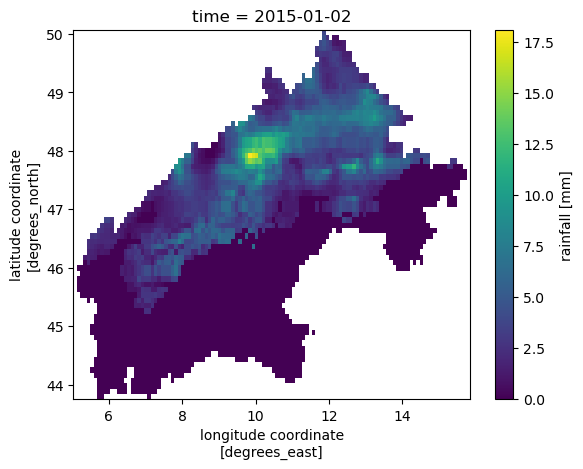

In [16]:
out[0].precip.isel(time=1).plot()

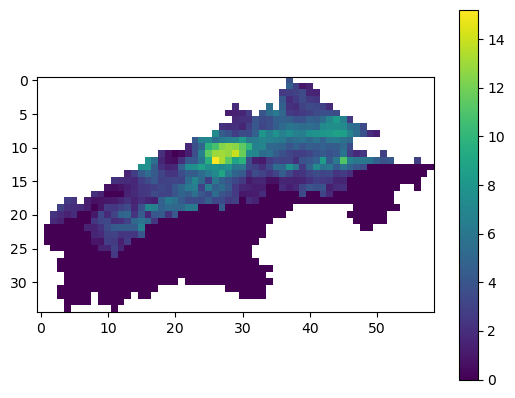

In [17]:
plt.imshow(out[0][...,1])
plt.colorbar()

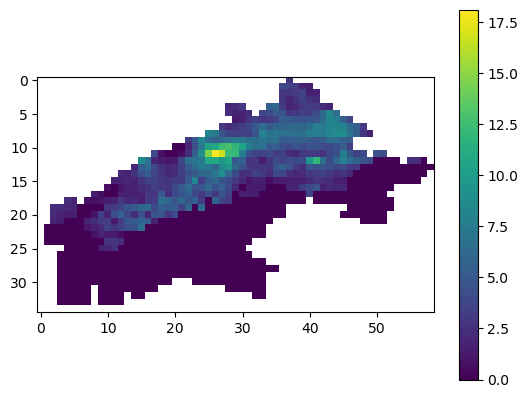

In [19]:
plt.imshow(out2[0][...,1])
plt.colorbar()

In [ ]:
from abc import ABC, abstractmethod
from typing import Tuple
from numpy.typing import NDArray

In [60]:
@dataclass
class SamplerMeta:
    idx_orig_2d: npt.NDArray
    idx_sampled_1d: npt.NDArray 

In [97]:
class BaseSampler(ABC):
    
    META = "ds"
    
    def __init__(self):
        pass

    @abstractmethod
    def sampling(self, grid) -> Tuple[NDArray, SamplerMeta]:
        pass

In [89]:
class RegularIntervalSampler(BaseSampler):

    def __init__(self, intervals, origin):
        self.intervals = intervals
        
    def sampling(self):
        pass

In [90]:
s = RegularIntervalSampler(1,2)

In [91]:
s.sampling()

In [46]:
from dataclasses import dataclass 
import numpy.typing as npt
import numpy as np

In [49]:
d = SamplerMeta(idx_orig_2d=np.array([]), idx_sampled_1d=np.array([]))